In [1]:
from get_args import get_args
args = ["--dataset", "cifar10_no_transform", "--exp", "bCR", "--num_channels", "4", "--num_channels_dae", "128", "--num_timesteps", "4", 
			"--num_res_blocks", "2", "--batch_size", "256", "--num_epoch", "1700", "--ngf", "64", "--nz", "50", "--z_emb_dim", "256", "--n_mlp", "4", "--embedding_type", "positional", 
			"--use_ema", "--ema_decay", "0.9999", "--r1_gamma", "0.02", "--lr_d", "1.25e-4", "--lr_g", "1.6e-4", "--lazy_reg", "15", 
			"--ch_mult", "1", "2", "2", "--save_content", "--datadir", "./data/cifar-10", 
			"--master_port", "6084", "--num_process_per_node", "1", "--save_ckpt_every", "5", 
			"--current_resolution", "16", "--attn_resolutions", "32", "--num_disc_layers", "4",  "--scale_factor", "105.0", 
			"--no_lr_decay", 
            "--AutoEncoder_config", "autoencoder/config/kl-f2.yaml", 
            "--AutoEncoder_ckpt", "autoencoder/weight/kl-f2.ckpt", 
			"--rec_loss",
			"--sigmoid_learning", 
       ]

args = get_args(args)

In [2]:
import argparse
import os
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from datasets_prep.dataset import create_dataset
from diffusion import sample_from_model, sample_posterior, \
    q_sample_pairs, get_time_schedule, \
    Posterior_Coefficients, Diffusion_Coefficients
#from DWT_IDWT.DWT_IDWT_layer import DWT_2D, IDWT_2D
#from pytorch_wavelets import DWTForward, DWTInverse
from torch.multiprocessing import Process
from utils import init_processes, copy_source, broadcast_params
import yaml

from ldm.util import instantiate_from_config
from omegaconf import OmegaConf
import wandb
from copy import deepcopy
from collections import OrderedDict

class ProbLoss(nn.Module):
    def __init__(self, opt):
        assert opt["loss_type"] in ["bce", "hinge"]
        super().__init__()
        self.loss_type = opt["loss_type"]
        self.device = opt["device"]
        self.ones = torch.ones(opt["batch_size"]).to(opt["device"])
        self.zeros = torch.zeros(opt["batch_size"]).to(opt["device"])
        self.bce = nn.BCEWithLogitsLoss()

    def __call__(self, logits, condition):
        assert condition in ["gen", "disc_real", "disc_fake"]
        batch_len = len(logits)

        if self.loss_type == "bce":
            if condition in ["gen", "disc_real"]:
                return self.bce(logits, self.ones[:batch_len])
            else:
                return self.bce(logits, self.zeros[:batch_len])
        
        elif self.loss_type == "hinge":
        # SPADEでのHinge lossを参考に実装
        # https://github.com/NVlabs/SPADE/blob/master/models/networks/loss.py        
            if condition == "gen":
                # Generatorでは、本物になるようにHinge lossを返す
                return -torch.mean(logits)
            elif condition == "disc_real":
                minval = torch.min(logits - 1, self.zeros[:batch_len])
                return -torch.mean(minval)
            else:
                minval = torch.min(-logits - 1, self.zeros[:batch_len])
                return -torch.mean(minval)

@torch.no_grad()
def update_ema(ema_model, model, decay=0.9999):
    """
    Step the EMA model towards the current model.
    """
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        name = name.replace("module.", "")
        # TODO: Consider applying only to params that require_grad to avoid small numerical changes of pos_embed
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)

def requires_grad(model, flag=True):
    """
    Set requires_grad flag for all parameters in a model.
    """
    for p in model.parameters():
        p.requires_grad = flag

def load_model_from_config(config_path, ckpt):
    print(f"Loading model from {ckpt}")
    config = OmegaConf.load(config_path)
    pl_sd = torch.load(ckpt, map_location="cpu")
    #global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.first_stage_model
    model.cuda()
    model.eval()
    del m
    del u
    del pl_sd
    return model

def grad_penalty_call(args, D_real, x_t):
    grad_real = torch.autograd.grad(
        outputs=D_real.sum(), inputs=x_t, create_graph=True
    )[0]
    grad_penalty = (
        grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()

    grad_penalty = args.r1_gamma / 2 * grad_penalty
    grad_penalty.backward(retain_graph=True)

In [3]:
dataset = create_dataset(args)
data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=8,
                                              shuffle=True,
                                              num_workers=args.num_workers,
                                              pin_memory=True,
                                              drop_last=True)

Files already downloaded and verified


In [4]:
from ldm.util import instantiate_from_config
device="cuda:0"
config_path = "./autoencoder/config/kl-f2.yaml"
ckpt_path = "./autoencoder/weight/kl-f2.ckpt"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

AutoEncoder = instantiate_from_config(config['model'])


checkpoint = torch.load(ckpt_path, map_location=device)
AutoEncoder.load_state_dict(checkpoint['state_dict'])
AutoEncoder.eval()
AutoEncoder.to(device)

making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
Working with z of shape (1, 4, 16, 16) = 1024 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels


/home/users/std/2021/21k0005/anaconda3/envs/iddgan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/users/std/2021/21k0005/anaconda3/envs/iddgan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.2, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

In [5]:
tmp = iter(data_loader)
x, y = next(tmp)

In [6]:
augment = transforms.RandomChoice([
        #transforms.RandomCrop(args.image_size, padding=4, padding_mode="reflect"), # ランダムな位置で切り取り
        transforms.RandomResizedCrop(size=args.image_size, scale=(0.7, 1.3)),    # ズームインとズームアウト
        #transforms.RandomRotation(degrees=30),                                   # 左右30度までのローテート
    ])

In [7]:
x_aug = augment(x.detach())

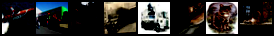

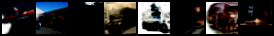

In [8]:
import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import display
from PIL import Image

grid_img = torchvision.utils.make_grid(x)

# TensorをPIL画像に変換して保存
ndarr = grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
im = Image.fromarray(ndarr)
display(im)

grid_img = torchvision.utils.make_grid(x_aug)

# TensorをPIL画像に変換して保存
ndarr = grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
im = Image.fromarray(ndarr)
display(im)

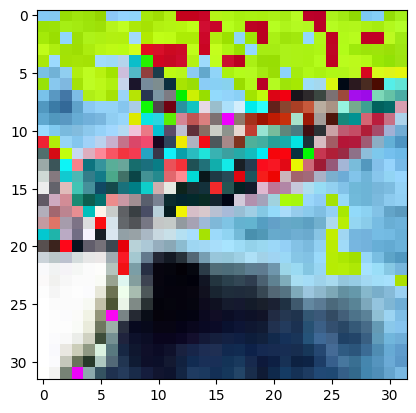

In [9]:
import matplotlib.pyplot as plt
from torchvision import transforms
img = transforms.ToPILImage(mode="RGB")(x[0])
plt.imshow(img)
plt.show()

In [10]:
x = x.to(device)
x_aug = x_aug.to(device)
with torch.no_grad():
    posterior = AutoEncoder.encode(x)
    real_data = posterior.sample().detach()
    posterior_aug = AutoEncoder.encode(x_aug)
    real_data_aug = posterior_aug.sample().detach()

In [11]:
args.scale_factor = 1.

In [12]:
real_data = real_data / args.scale_factor
real_data_aug = real_data_aug / args.scale_factor

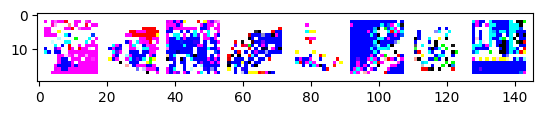

In [13]:
import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import display
from PIL import Image

grid_img = torchvision.utils.make_grid(real_data)

# TensorをPIL画像に変換して保存
plt.imshow(grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy())

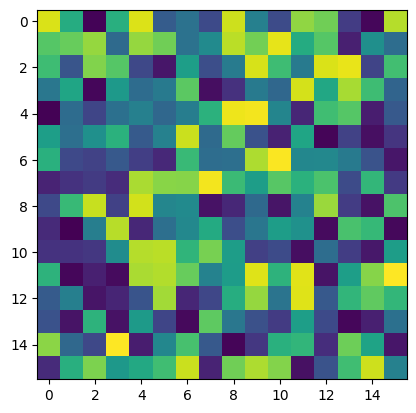

In [14]:
img = transforms.ToPILImage(mode="L")(real_data[0][3])
plt.imshow(img)

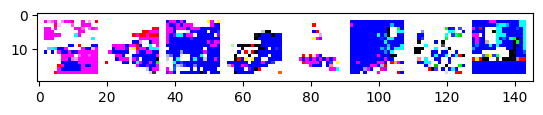

In [15]:
grid_img = torchvision.utils.make_grid(real_data_aug)

# TensorをPIL画像に変換して保存
plt.imshow(grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy())

In [16]:
real_data = real_data * args.scale_factor
real_data_aug = real_data_aug * args.scale_factor

In [17]:
with torch.no_grad():
    real_data = AutoEncoder.decode(real_data)
    real_data_aug = AutoEncoder.decode(real_data_aug)

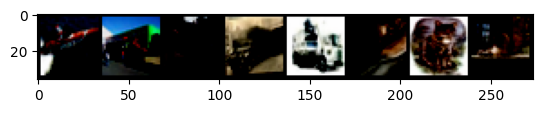

In [18]:
import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import display
from PIL import Image

grid_img = torchvision.utils.make_grid(real_data)

# TensorをPIL画像に変換して保存
plt.imshow(grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy())

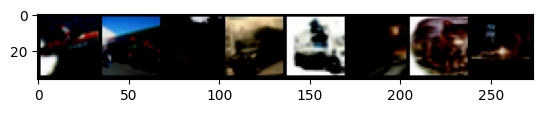

In [19]:
grid_img = torchvision.utils.make_grid(real_data_aug)

# TensorをPIL画像に変換して保存
plt.imshow(grid_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy())

In [ ]:
def train(rank, gpu, args):
    from EMA import EMA
    from score_sde.models.discriminator import Discriminator_large, Discriminator_small
    from score_sde.models.ncsnpp_generator_adagn import NCSNpp, WaveletNCSNpp

    torch.manual_seed(args.seed + rank)
    torch.cuda.manual_seed(args.seed + rank)
    torch.cuda.manual_seed_all(args.seed + rank)
    device = torch.device('cuda:{}'.format(gpu))

    batch_size = args.batch_size

    nz = args.nz  # latent dimension

    dataset = create_dataset(args)
    #train_sampler = torch.utils.data.distributed.DistributedSampler(dataset,
    #                                                                num_replicas=args.world_size,
    #                                                                rank=rank)
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=args.num_workers,
                                              pin_memory=True,
                                              #sampler=train_sampler,
                                              drop_last=True)
    args.ori_image_size = args.image_size
    args.image_size = args.current_resolution
    G_NET_ZOO = {"normal": NCSNpp, "wavelet": WaveletNCSNpp}
    gen_net = G_NET_ZOO[args.net_type]
    disc_net = [Discriminator_small, Discriminator_large]
    print("GEN: {}, DISC: {}".format(gen_net, disc_net))
    netG = gen_net(args).to(device)

    if args.dataset in ['cifar10', 'stl10']:
        netD = disc_net[0](nc=2 * args.num_channels, ngf=args.ngf,
                           t_emb_dim=args.t_emb_dim,
                           act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)
    else:
        netD = disc_net[1](nc=2 * args.num_channels, ngf=args.ngf,
                           t_emb_dim=args.t_emb_dim,
                           act=nn.LeakyReLU(0.2), num_layers=args.num_disc_layers).to(device)

    #broadcast_params(netG.parameters())
    #broadcast_params(netD.parameters())

    optimizerD = optim.Adam(filter(lambda p: p.requires_grad, netD.parameters(
    )), lr=args.lr_d, betas=(args.beta1, args.beta2))
    optimizerG = optim.Adam(filter(lambda p: p.requires_grad, netG.parameters(
    )), lr=args.lr_g, betas=(args.beta1, args.beta2))

    #if args.use_ema:
    #    optimizerG = EMA(optimizerG, ema_decay=args.ema_decay)
    
    ema = deepcopy(netG).to(device)  # Create an EMA of the model for use after training
    requires_grad(ema, False)

    schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizerG, args.num_epoch, eta_min=1e-5)
    schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizerD, args.num_epoch, eta_min=1e-5)

    # ddp
    #netG = nn.parallel.DistributedDataParallel(netG, device_ids=[gpu]
    #netD = nn.parallel.DistributedDataParallel(netD, device_ids=[gpu])

    """############### DELETE TO AVOID ERROR ###############"""
    # Wavelet Pooling
    #if not args.use_pytorch_wavelet:
    #    dwt = DWT_2D("haar")
    #    iwt = IDWT_2D("haar")
    #else:
    #    dwt = DWTForward(J=1, mode='zero', wave='haar').cuda()
    #    iwt = DWTInverse(mode='zero', wave='haar').cuda()
        
    
    #load encoder and decoder
    config_path = args.AutoEncoder_config 
    ckpt_path = args.AutoEncoder_ckpt 
    
    if args.dataset in ['cifar10', 'stl10'] or True:

        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
        
        AutoEncoder = instantiate_from_config(config['model'])
        

        checkpoint = torch.load(ckpt_path, map_location=device)
        AutoEncoder.load_state_dict(checkpoint['state_dict'])
        AutoEncoder.eval()
        AutoEncoder.to(device)
    
    else:
        AutoEncoder = load_model_from_config(config_path, ckpt_path)
    """############### END DELETING ###############"""
    
    num_levels = int(np.log2(args.ori_image_size // args.current_resolution))

    exp = args.exp
    parent_dir = "./saved_info/{}".format(args.dataset)

    exp_path = os.path.join(parent_dir, exp)
    if rank == 0:
        if not os.path.exists(exp_path):
            os.makedirs(exp_path)
            copy_source(__file__, exp_path)
            shutil.copytree('score_sde/models',
                            os.path.join(exp_path, 'score_sde/models'))

    coeff = Diffusion_Coefficients(args, device)
    pos_coeff = Posterior_Coefficients(args, device)
    T = get_time_schedule(args, device)

    if args.resume or os.path.exists(os.path.join(exp_path, 'content.pth')):
        checkpoint_file = os.path.join(exp_path, 'content.pth')
        checkpoint = torch.load(checkpoint_file, map_location=device)
        init_epoch = checkpoint['epoch']
        epoch = init_epoch
        # load G
        netG.load_state_dict(checkpoint['netG_dict'])
        #optimizerG.load_state_dict(checkpoint['optimizerG'])
        schedulerG.load_state_dict(checkpoint['schedulerG'])
        # load D
        netD.load_state_dict(checkpoint['netD_dict'])
        #optimizerD.load_state_dict(checkpoint['optimizerD'])
        schedulerD.load_state_dict(checkpoint['schedulerD'])

        global_step = checkpoint['global_step']
        print("=> loaded checkpoint (epoch {})"
              .format(checkpoint['epoch']))
    else:
        global_step, epoch, init_epoch = 0, 0, 0

    '''Sigmoid learning parameter'''
    gamma = 6
    beta = np.linspace(-gamma, gamma, args.num_epoch+1)
    alpha = 1 - 1 / (1+np.exp(-beta))

    # 拡張の候補を定義
    augment = transforms.RandomChoice([
        transforms.RandomCrop(args.image_size, padding=4, padding_mode="reflect"), # ランダムな位置で切り取り
        transforms.RandomResizedCrop(size=args.image_size, scale=(0.8, 1.2)),    # ズームインとズームアウト
        transforms.RandomRotation(degrees=30),                                   # 左右30度までのローテート
    ])
    
    print(f"AutoEncoder Parameters: {sum(p.numel() for p in AutoEncoder.parameters()):,}")
    print(f"Generator Parameters: {sum(p.numel() for p in netG.parameters()):,}")
    print(f"Discriminator Parameters: {sum(p.numel() for p in netD.parameters()):,}")

    #loss = ProbLoss({"device":device, "batch_size":args.batch_size, "loss_type":args.loss_type})
    loss = nn.MSELoss()
    
    update_ema(ema, netG, decay=0)  # Ensure EMA is initialized with synced weights
    ema.eval()

    for epoch in range(init_epoch, args.num_epoch + 1):
        #train_sampler.set_epoch(epoch)

        for iteration, (x, y) in enumerate(data_loader):
            requires_grad(netD)
            netD.zero_grad()

            requires_grad(netG, flag=False)

            # sample from p(x_0)
            x0 = x.to(device, non_blocking=True)
            x0_aug = augment(x0.detach())

            """################# Change here: Encoder #################"""
            with torch.no_grad():
                posterior = AutoEncoder.encode(x0)
                real_data = posterior.sample().detach()
                posterior_aug = AutoEncoder.encode(x0_aug)
                real_data_aug = posterior_aug.sample().detach()
            #print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
            real_data = real_data / args.scale_factor #300.0  # [-1, 1]
            real_data_aug = real_data_aug / args.scale_factor #300.0  # [-1, 1]
            
            
            #assert -1 <= real_data.min() < 0
            #assert 0 < real_data.max() <= 1
            """################# End change: Encoder #################"""
            # sample t
            t = torch.randint(0, args.num_timesteps,
                              (real_data.size(0),), device=device)

            x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)
            x_t_aug, x_tp1_aug = q_sample_pairs(coeff, real_data_aug, t)
            x_t.requires_grad = True
            x_t_aug.requires_grad = True

            # train with real
            D_real = netD(x_t, t, x_tp1.detach()).view(-1)
            D_real_aug = netD(x_t_aug, t, x_tp1_aug.detach()).view(-1)
            
            loss_real = F.softplus(-D_real).mean() #+ args.lambda_real * loss(D_real, D_real_aug)
            
            loss_real.backward(retain_graph=True)

            
            if args.lazy_reg is None:
                grad_penalty_call(args, D_real, x_t)
            else:
                if global_step % args.lazy_reg == 0:
                    grad_penalty_call(args, D_real, x_t)
            

            # train with fake
            latent_z = torch.randn(batch_size, nz, device=device)
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
            x_0_predict_aug = netG(x_tp1_aug.detach(), t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            x_pos_sample_aug = sample_posterior(pos_coeff, x_0_predict_aug, x_tp1_aug, t)

            D_fake = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
            D_fake_aug = netD(x_pos_sample_aug, t, x_tp1_aug.detach()).view(-1)
            
            

            # bCRの正則化項を追加 (λ_real, λ_fakeはハイパーパラメータ)
            #real_loss = torch.mean((D_real - D_real_aug)**2)
            #fake_loss = torch.mean((D_fake - D_fake_aug)**2)
            #consistency_loss = (D_fake - D_real).mean() + args.lambda_real * real_loss + args.lambda_fake * fake_loss
            
            #optimizerD.zero_grad()
            #consistency_loss.backward()
            
            loss_fake = F.softplus(D_fake).mean() #+ args.lambda_fake * loss(D_fake, D_fake_aug)
            loss_fake.backward()

            errD = loss_real + loss_fake
            # Update D
            optimizerD.step()

            # update G
            requires_grad(netD, flag=False)

            requires_grad(netG)
            netG.zero_grad()

            t = torch.randint(0, args.num_timesteps,
                              (real_data.size(0),), device=device)
            x_t, x_tp1 = q_sample_pairs(coeff, real_data, t)

            latent_z = torch.randn(batch_size, nz, device=device)
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)

            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
            errG = F.softplus(-output).mean()

            # reconstructior loss
            if args.sigmoid_learning and args.rec_loss:
                ######alpha
                rec_loss = F.l1_loss(x_0_predict, real_data)
                errG = errG + alpha[epoch]*rec_loss

            elif args.rec_loss and not args.sigmoid_learning:
                rec_loss = F.l1_loss(x_0_predict, real_data)
                errG = errG + rec_loss
            

            errG.backward()
            optimizerG.step()
            update_ema(ema, netG)
            

            global_step += 1
            if iteration % 100 == 0:
                if rank == 0:
                    if args.sigmoid_learning:
                        print('epoch {} iteration{}, G Loss: {}, D Loss: {}, alpha: {}'.format(
                            epoch, iteration, errG.item(), errD.item(), alpha[epoch]))
                    elif args.rec_loss:
                        print('epoch {} iteration{}, G Loss: {}, D Loss: {}, rec_loss: {}'.format(
                            epoch, iteration, errG.item(), errD.item(), rec_loss.item()))
                    else:   
                        print('epoch {} iteration{}, G Loss: {}, D Loss: {}'.format(
                            epoch, iteration, errG.item(), errD.item()))

        if not args.no_lr_decay:

            schedulerG.step()
            schedulerD.step()

        if rank == 0:
            wandb.log({"G_loss": errG.item(), "D_loss": errD.item(), "alpha": alpha[epoch]})
            ########################################
            x_t_1 = torch.randn_like(posterior.sample())
            fake_sample = sample_from_model(
                pos_coeff, netG, args.num_timesteps, x_t_1, T, args)

            """############## CHANGE HERE: DECODER ##############"""
            fake_sample *= args.scale_factor #300
            real_data *= args.scale_factor #300
            with torch.no_grad():
                fake_sample = AutoEncoder.decode(fake_sample)
                real_data = AutoEncoder.decode(real_data)
            
            #fake_sample = (torch.clamp(fake_sample, -1, 1) + 1) / 2  # 0-1
            #real_data = (torch.clamp(real_data, -1, 1) + 1) / 2  # 0-1 
            
            """############## END HERE: DECODER ##############"""

            torchvision.utils.save_image(fake_sample, os.path.join(
                exp_path, 'sample_discrete_epoch_{}.png'.format(epoch)))
            torchvision.utils.save_image(
                real_data, os.path.join(exp_path, 'real_data.png'))

            if args.save_content:
                if epoch % args.save_content_every == 0:
                    print('Saving content.')
                    content = {'epoch': epoch + 1, 'global_step': global_step, 'args': args,
                               'netG_dict': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                               'schedulerG': schedulerG.state_dict(), 'netD_dict': netD.state_dict(),
                               'optimizerD': optimizerD.state_dict(), 'schedulerD': schedulerD.state_dict()}
                    torch.save(content, os.path.join(exp_path, 'content.pth'))

            if epoch % args.save_ckpt_every == 0:
                #if args.use_ema:
                #    optimizerG.swap_parameters_with_ema(
                #        store_params_in_ema=True)

                torch.save(netG.state_dict(), os.path.join(
                    exp_path, 'netG_{}.pth'.format(epoch)))
                #if args.use_ema:
                #    optimizerG.swap_parameters_with_ema(
                #        store_params_in_ema=True)

In [ ]:
wandb.init(
            project="bCR",
            name=args.exp,
            config={
                "dataset": args.dataset,
                "image_size": args.image_size,
                "channels": args.num_channels,
                "channels_dae": args.num_channels_dae,
                "ch_nult": args.ch_mult,
                "timesteps": args.num_timesteps,
                "res_blocks": args.num_res_blocks,
                "nz": args.nz,
                "epochs": args.num_epoch,
                "ngf": args.ngf,
                "lr_g": args.lr_g,
                "lr_d": args.lr_d,
                "batch_size": args.batch_size,
                "r1_gamma": args.r1_gamma,
                "lazy_reg": args.lazy_reg,
                "embedding_type": args.embedding_type,
                "use_ema": args.use_ema,
                "ema_decay": args.ema_decay,
                "no_lr_decay": args.no_lr_decay,
                "z_emb_dim": args.z_emb_dim,
                "attn_resolutions": args.attn_resolutions,
                "use_pytorch_wavelet": args.use_pytorch_wavelet,
                "rec_loss": args.rec_loss,
                "net_type": args.net_type,
                "num_disc_layers": args.num_disc_layers,
                "no_use_fbn": args.no_use_fbn,
                "no_use_freq": args.no_use_freq,
                "no_use_residual": args.no_use_residual,
                "scale_factor": args.scale_factor,
                "AutoEncoder_config": args.AutoEncoder_config,
                "AutoEncoder_ckpt": args.AutoEncoder_ckpt,
                "sigmoid_learning": args.sigmoid_learning,
            }
        )

In [ ]:
print('starting in debug mode')
init_processes(0, 1, train, args)